In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
isotopes_df = pd.read_csv('../data/clean_isotopic_weights.csv')

x_min = 175
x_max = 400

def get_mass(element,count):
    #### Randomly pick (weighted) an isotope from isotopes_df
    isotopes = isotopes_df[isotopes_df['Element'] == element]
    return np.random.choice(a=isotopes['Mass'],p=isotopes['Weight'],size=count)    

In [6]:
def generate_isotopic_pattern(chemical_formula, number_runs=1000):
    #### Generates weighted random distribution of isotopomers
    iteration = 0
    masses = [None] * number_runs
    while iteration < number_runs:
        total_mass = 0
        for element in chemical_formula.keys():
            count = chemical_formula[element]
            total_mass += np.sum(get_mass(element,count))
        
        masses[iteration] = total_mass
        iteration += 1

    #### Using np.histogram and plotting a bar chart is significantly faster than using plt.hist()!
    masses = np.histogram(masses,range=(x_min,x_max),bins=(x_max-x_min),density=False)
    return masses 

In [4]:
def virtual_imine_condensation(aldehyde, amine):
    imine = {}
    for element in isotopes_df['Element']:
        #### There's certainly a more elegant way to do this
        if (element in aldehyde) and (element in amine):
            imine[element] = aldehyde[element] + amine[element]
        elif element in aldehyde:
            imine[element] = aldehyde[element]
        elif element in amine:
            imine[element] = amine[element]
    
    if 'O' in imine:
        if imine['O'] == 1:
            imine.pop('O')
        else:
            imine['O'] += -1
    
    imine['H'] += -2
    
    return imine

In [41]:
aldehydes = [{'C':6,'H':12,'O':1},{'C':2,'H':4,'O':1},{'C':5,'H':10,'O':1},{'C':8,'H':8,'O':1},{'C':8,'H':8,'O':2}]
amines = [{'C':10,'H':12,'N':2},{'C':17,'H':18,'N':2,'O':1},{'C':10,'H':11,'N':2,'Cl':1},{'C':10,'H':11,'N':2,'F':1},{'C':11,'H':14,'N':2,'O':1}]

aldehyde_labels = ['nPent','Me','tBu','MePh','4OMePh']
amine_labels = ['H','5OBn','5Cl','5F','6OMe']

masses = [None] * (len(aldehydes) * len(amines))
labels = [None] * (len(aldehydes) * len(amines))

count = 0
for i, aldehyde in enumerate(aldehydes):
    for j, amine in enumerate(amines):
        imine = virtual_imine_condensation(aldehyde,amine)
        pattern = generate_isotopic_pattern(imine)
        masses[count] = pattern
        labels[count] = str(aldehyde_labels[i]) + "-" + str(amine_labels[j])
        count += 1

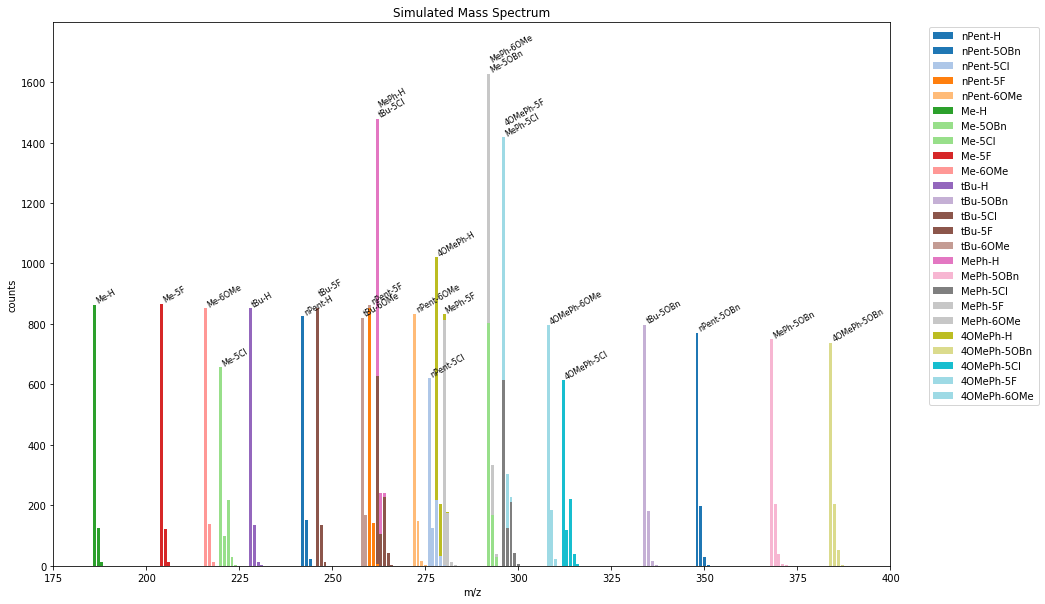

In [52]:
low_res_mass = np.arange(x_min,x_max,1)
figure, axes = plt.subplots(figsize=(15,10))
axes.set_xlim(left=x_min,right=x_max)

colors = plt.cm.tab20(np.linspace(0,1,len(masses)))

cumulative = [0] * len(low_res_mass)

for index, values in enumerate(masses):
    #### Draw the bar chart and raise the threshold
    patches = plt.bar(x=low_res_mass,height=values[0],label=labels[index],color=colors[index],bottom=cumulative)
    cumulative += values[0]

for index, values in enumerate(masses):
    max_index = np.argmax(values[0])
    axes.text(patches[max_index].get_x() + patches[max_index].get_width()/2, cumulative[max_index] + 5, labels[index], ha='left',rotation=30,size=8)
   
    #### Prevent overlapping labels - little kludgy but works surprisingly well
    for x in np.arange(max_index,max_index+5,1):
        if np.abs(cumulative[x] - cumulative[max_index]) < 100:
            cumulative[x] += 35 

axes.set_ylim(bottom=0,top=np.max(cumulative) + 100)

plt.legend(loc='upper left', bbox_to_anchor=(1.04,1))
plt.xlabel('m/z')
plt.ylabel('counts')
plt.title('Simulated Mass Spectrum')
plt.show()